<a href="https://colab.research.google.com/github/hayashiyus/First-steps-towards-Deep-Learning/blob/main/20_Linear-regression-models.ipynb" target="_parent">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title install packages
'''
!pip install loss_landscapes
!pip install mplcyberpunk
!pip install watermark
!pip install functorch
'''

'\n!pip install loss_landscapes\n!pip install mplcyberpunk\n!pip install watermark\n!pip install functorch\n'

In [2]:
import mplcyberpunk

In [3]:
import copy
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from functorch import make_functional, vmap, vjp, jvp, jacrev
import loss_landscapes
import loss_landscapes.metrics
from sklearn.model_selection import train_test_split

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
np.random.seed(0)
torch.manual_seed(0)

### **1.　勾配降下法**
訓練誤差を小さくする方向にパラメータを動かしていく操作をパラメータ更新と呼びます．勾配降下法を使ってニューラルネットのウェイトやバイアスをパラメータ更新していくことで，
ニューラルネットのパフォーマンスが改善することを確認しましょう．

$$\begin{aligned}
w_{i j}^{(\ell)}(t+1) &= w_{i j}^{(\ell)}(t) - \eta\frac{\partial L(\boldsymbol{\theta})}{\partial w_{i j}^{(\ell)}(t)}
\end{aligned}$$

##### **問1：勾配降下法**
観測データを生成する真のモデルが $y = x^2\sin(x)\cos(x)+\varepsilon$ の場合，真のモデルから100個のサンプルを生成してください．<br>
また，作成した人工データをプロットしてください．

##### **例1**

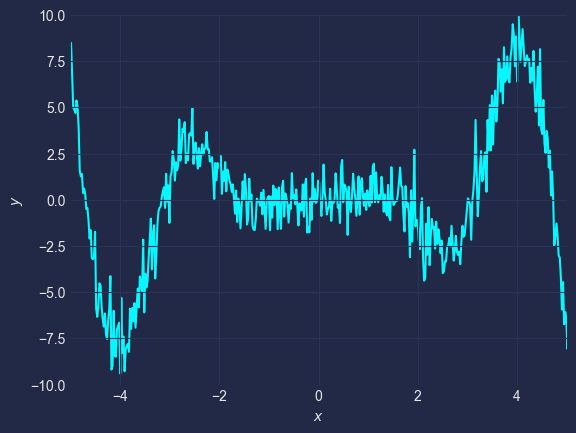

In [6]:
# 真のモデル
def f(x):
    return torch.square(x) * torch.sin(x) * torch.cos(x) + torch.normal(0, 1, size=x.size())

# 人工データのサンプル数
num_samples = 500
X = torch.linspace(-5.5, 5.5, num_samples)
y = f(X)
X = X.unsqueeze(1).to(torch.float32)
y = y.unsqueeze(1).to(torch.float32)

plt.style.use("cyberpunk")
plt.plot(X, y, zorder=0)
plt.xlim(xmin=-5, xmax=5)
plt.ylim(ymin=-10, ymax=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

##### **問2：勾配降下法**
幅が$2^9(=512)$ユニットの中間層を1つだけ持つニューラルネットを作成し，人工データを使ってモデルを訓練させてください．

##### **例2**

In [7]:
# 等高線の間隔
steps = 100
# エポック数
epochs = 500
# 学習率
learning_rate = 1/1000
# バッチサイズ
train_batch_size = int(0.8 * num_samples/2)
# バッチサイズ
val_batch_size = int(0.2 * num_samples/2)

In [8]:
# 中間層の幅
width = 10

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, width),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(width, width),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(width, 1))
    def forward(self, X):
        y_hat = self.regressor(X)
        return y_hat

model = NeuralNetwork()

# 損失関数として2乗誤差を選択
criterion = nn.MSELoss()
# 勾配降下法として確率的勾配降下法を採用
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 訓練データとテストデータを作成
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
train_loader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=train_batch_size,
                          pin_memory=True, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=val_batch_size,
                        pin_memory=True, shuffle=True)

train_loss = []
val_loss = []
for epoch in np.arange(epochs):
    # エポック毎にモデルの訓練と評価を繰り返す
    # モデルの訓練
    model.train()
    temp_train_loss = []
    for X_train, y_train in train_loader:             # データローダーから訓練データ（バッチ）を抽出
        optimizer.zero_grad()                         # 勾配情報を初期化
        y_hat = model(X_train)                        # 出力の予測値を生成
        loss = criterion(input=y_hat, target=y_train) # 損失関数に出力の予測値と正解の出力を代入し訓練誤差を計算
        loss.backward()                               # パラメータ毎に訓練誤差の勾配を計算
        optimizer.step()                              # 勾配降下法によるパラメータ更新
        temp_train_loss.append(loss.detach())
    train_loss.append(np.average(temp_train_loss))    # 訓練誤差をリストに保存
    # モデルの評価
    model.eval()
    temp_val_loss = []
    for X_val, y_val in val_loader:
        y_hat = model(X_val)                          # データローダーからテストデータ（バッチ）を抽出
        loss = criterion(input=y_hat, target=y_val)   # 損失関数に出力の予測値と正解の出力を代入して汎化誤差の近似値を計算
        temp_val_loss.append(loss.detach())
    val_loss.append(np.average(temp_val_loss))        # 汎化誤差の近似値をリストに保存

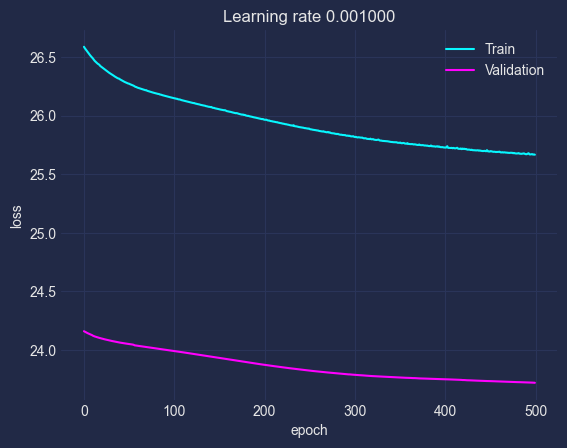

In [9]:
# エポック毎の訓練誤差と汎化誤差の近似値をプロット
plt.style.use("cyberpunk")
plt.plot(train_loss, label='Train')
plt.plot(val_loss, c='magenta', label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend()
plt.show()

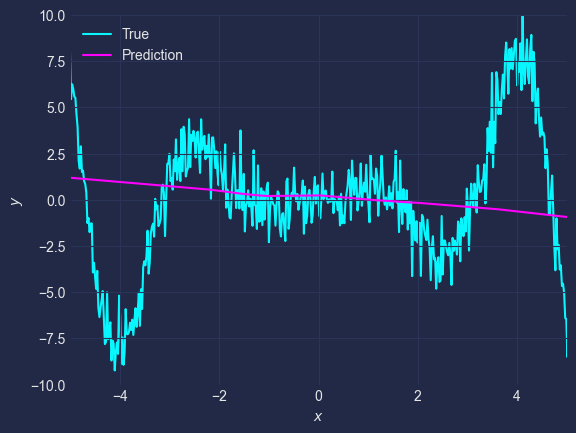

In [10]:
plt.style.use("cyberpunk")
plt.plot(X, f(X).detach(), zorder=0, label='True')
plt.plot(X, model(X).detach(), zorder=1, c='magenta', label='Prediction')
plt.xlim(xmin=-5, xmax=5)
plt.ylim(ymin=-10, ymax=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

##### **問3：勾配降下法**
学習済みモデルの損失ランドスケープをプロットしてください．

##### **例3**

In [11]:
trained_model = copy.deepcopy(model)

metric = loss_landscapes.metrics.Loss(criterion, X_train, y_train)

loss_data_fin = loss_landscapes.random_plane(trained_model, metric, 10, steps, normalization='filter', deepcopy_model=True)

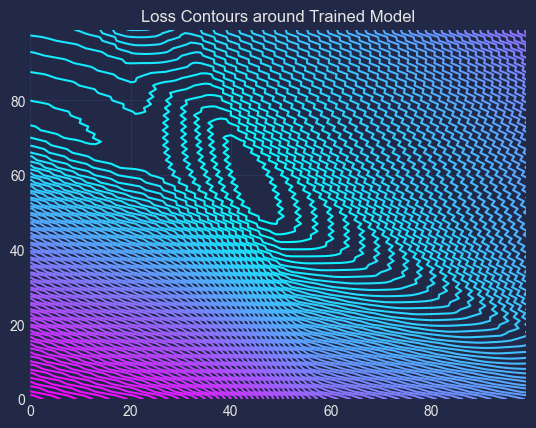

In [12]:
plt.style.use("cyberpunk")
plt.contour(loss_data_fin, levels=steps)
plt.title('Loss Contours around Trained Model')
plt.show()

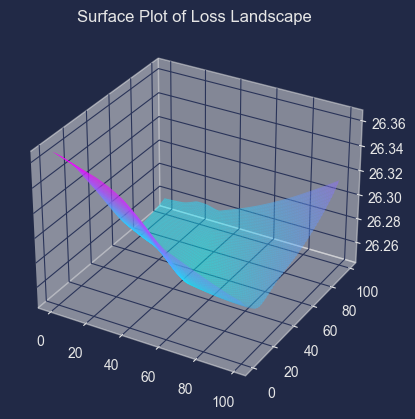

In [13]:
plt.style.use("cyberpunk")
fig = plt.figure()
ax = plt.axes(projection='3d')
xx = np.array([[j for j in range(steps)] for i in range(steps)])
yy = np.array([[i for _ in range(steps)] for i in range(steps)])
ax.plot_surface(xx, yy, loss_data_fin, rstride=1, cstride=1, edgecolor='none', alpha=.5, cmap=cm.cool)
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [14]:
# 中間層の幅
width = 3 * 10**3

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, width),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(width, width),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(width, 1))
    def forward(self, X):
        y_hat = self.regressor(X)
        return y_hat

model = NeuralNetwork()

# 損失関数として2乗誤差を選択
criterion = nn.MSELoss()
# 勾配降下法として確率的勾配降下法を採用
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 訓練データとテストデータを作成
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
train_loader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=train_batch_size,
                          pin_memory=True, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=val_batch_size,
                        pin_memory=True, shuffle=True)

train_loss = []
val_loss = []
for epoch in np.arange(epochs):
    # エポック毎にモデルの訓練と評価を繰り返す
    # モデルの訓練
    model.train()
    temp_train_loss = []
    for X_train, y_train in train_loader:             # データローダーから訓練データ（バッチ）を抽出
        optimizer.zero_grad()                         # 勾配情報を初期化
        y_hat = model(X_train)                        # 出力の予測値を生成
        loss = criterion(input=y_hat, target=y_train) # 損失関数に出力の予測値と正解の出力を代入し訓練誤差を計算
        loss.backward()                               # パラメータ毎に訓練誤差の勾配を計算
        optimizer.step()                              # 勾配降下法によるパラメータ更新
        temp_train_loss.append(loss.detach())
    train_loss.append(np.average(temp_train_loss))    # 訓練誤差をリストに保存
    # モデルの評価
    model.eval()
    temp_val_loss = []
    for X_val, y_val in val_loader:
        y_hat = model(X_val)                          # データローダーからテストデータ（バッチ）を抽出
        loss = criterion(input=y_hat, target=y_val)   # 損失関数に出力の予測値と正解の出力を代入して汎化誤差の近似値を計算
        temp_val_loss.append(loss.detach())
    val_loss.append(np.average(temp_val_loss))        # 汎化誤差の近似値をリストに保存

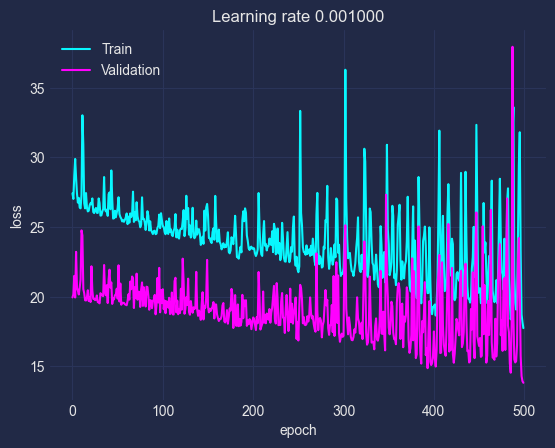

In [15]:
# エポック毎の訓練誤差と汎化誤差の近似値をプロット
plt.style.use("cyberpunk")
plt.plot(train_loss, label='Train')
plt.plot(val_loss, c='magenta', label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend()
plt.show()

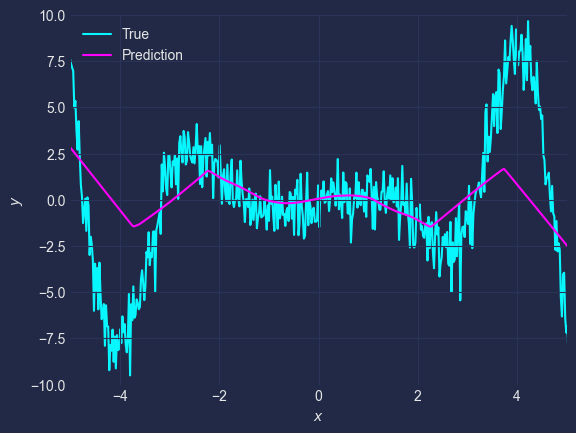

In [16]:
plt.style.use("cyberpunk")
plt.plot(X, f(X).detach(), zorder=0, label='True')
plt.plot(X, model(X).detach(), zorder=1, c='magenta', label='Prediction')
plt.xlim(xmin=-5, xmax=5)
plt.ylim(ymin=-10, ymax=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

In [17]:
trained_model = copy.deepcopy(model)

metric = loss_landscapes.metrics.Loss(criterion, X_train, y_train)

loss_data_fin = loss_landscapes.random_plane(trained_model, metric, 10, steps, normalization='filter', deepcopy_model=True)

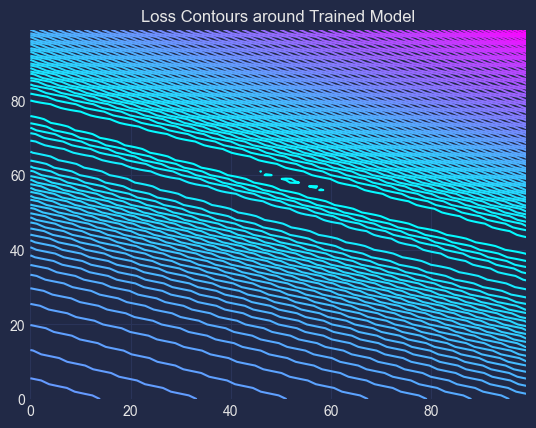

In [18]:
plt.style.use("cyberpunk")
plt.contour(loss_data_fin, levels=steps)
plt.title('Loss Contours around Trained Model')
plt.show()

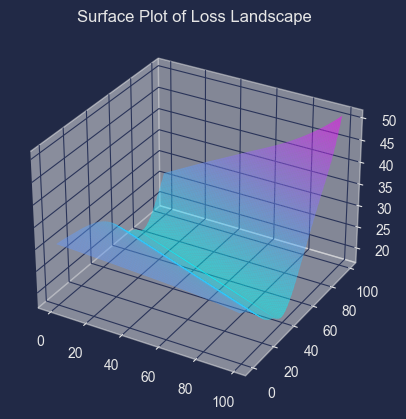

In [19]:
plt.style.use("cyberpunk")
fig = plt.figure()
ax = plt.axes(projection='3d')
xx = np.array([[j for j in range(steps)] for i in range(steps)])
yy = np.array([[i for _ in range(steps)] for i in range(steps)])
ax.plot_surface(xx, yy, loss_data_fin, rstride=1, cstride=1, edgecolor='none', alpha=.5, cmap=cm.cool)
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

### **2.　活性化関数**
活性化関数には様々な種類があり，今も新しい活性化関数が提案されています．

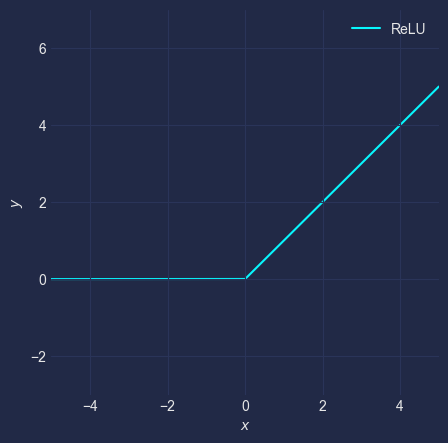

In [20]:
# 人工データのサンプル数
num_samples = 10**4
X = torch.linspace(-5, 5, num_samples)

# relu(x)
plt.style.use("cyberpunk")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(X, F.relu(X), zorder=0, label='ReLU')
ax.set_xlim(-5, 5)
ax.set_ylim(-3, 7)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend()

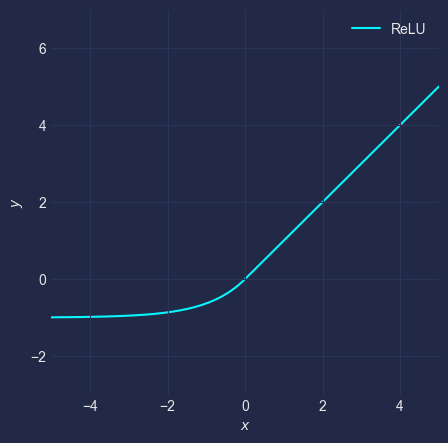

In [21]:
# elu(x)
plt.style.use("cyberpunk")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(X, F.elu(X), zorder=0, label='ReLU')
ax.set_xlim(-5, 5)
ax.set_ylim(-3, 7)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend()

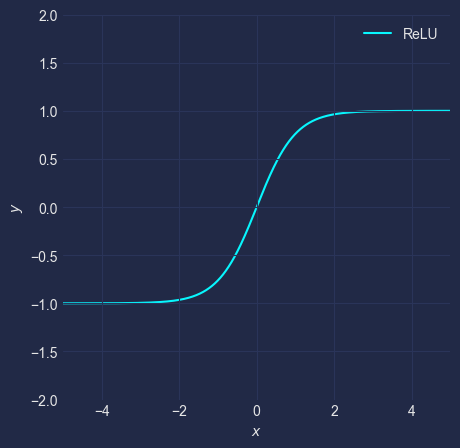

In [22]:
# tanh(x)
plt.style.use("cyberpunk")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(X, F.tanh(X), zorder=0, label='ReLU')
ax.set_xlim(-5, 5)
ax.set_ylim(-2, 2)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend()

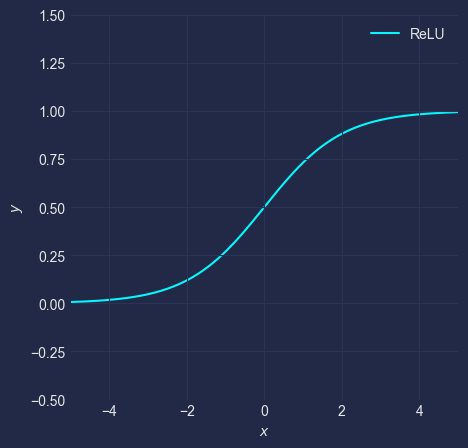

In [23]:
# sigmoid(x)
plt.style.use("cyberpunk")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(X, F.sigmoid(X), zorder=0, label='ReLU')
ax.set_xlim(-5, 5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend()

### **3.　誤差逆伝播法**
線形回帰モデル向けの人工データを作り，人工データを最もよく説明する（＝訓練誤差の少ない）係数パラメータを求めよう

$$\begin{aligned}
w_{i j}^{(\ell)}(t+1) &= w_{i j}^{(\ell)}(t) - \eta\frac{\partial L(\boldsymbol{\theta})}{\partial w_{i j}^{(\ell)}(t)} \\
\frac{\partial L(\boldsymbol{\theta})}{\partial w_{i j}^{(\ell)}} &= \sum_{k} \frac{\partial L(\boldsymbol{\theta})}{\partial \hat{y}_k} \frac{\partial \hat{y}_k}{\partial w_{i j}^{(\ell)}}
\end{aligned}$$

ここで $z_j^{(\ell)}=f\left(u_j^{(\ell)}\right),\ u_i^{(\ell)}=\sum_{j} w_{i j}^{(\ell)} f\left(u_j^{(\ell-1)}\right)=\sum_{j} w_{i j}^{(\ell)} z_j^{(\ell-1)}$ だから

$$\frac{\partial L(\boldsymbol{\theta})}{\partial w_{i j}^{(\ell)}}=\sum_{i} \frac{\partial L(\boldsymbol{\theta})}{\partial u_i^{(\ell)}} \frac{\partial u_i^{(\ell)}}{\partial w_{i j}^{(\ell)}}=\frac{\partial L(\boldsymbol{\theta})}{\partial u_i^{(\ell)}} z_j^{(\ell-1)} \equiv \delta_i^{(\ell)} z_j^{(\ell-1)}$$

更に $u_k^{(\ell+1)}=\sum_{m} w_{k m}^{(\ell+1)} f\left(u_{m}^{(\ell)}\right)$ を思い出すと

$$\delta_i^{(\ell)}=\sum_{k} \frac{\partial L(\boldsymbol{\theta})}{\partial u_k^{(\ell+1)}} \frac{\partial u_k^{(\ell+1)}}{\partial u_i^{(\ell)}}=\sum_k \delta_k^{(\ell+1)} w_{k i}^{(\ell+1)} f^{\prime}\left(u_i^{(\ell)}\right)$$

が導けた．つまり，デルタという量は$\ell+1$層から$\ell$層へ逆向きに伝播する．

##### **問3：誤差逆伝播法**
観測データを生成する真のモデルが y = w0 + w1 * x + ε の場合，真のモデルから50個のサンプルを生成してください．<br>
また，作成した人工データをプロットしてください．ただし，係数パラメータ w0, w1 の値は自由に決めて良いとします．

##### **例3**

In [24]:
# 中間層の幅
width = 2

model = nn.Sequential(nn.Linear(1, width),
                      nn.ReLU(inplace=True),
                      nn.Linear(width, 1))

# 損失関数として2乗誤差を選択
criterion = nn.MSELoss()
# 勾配降下法として確率的勾配降下法を採用
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
train_loss = []
val_loss = []
for epoch in np.arange(epochs):
    # エポック毎にモデルの訓練と評価を繰り返す
    # モデルの訓練
    model.train()
    temp_train_loss = []
    for X_train, y_train in train_loader:             # データローダーから訓練データ（バッチ）を抽出
        optimizer.zero_grad()                         # 勾配情報を初期化
        y_hat = model(X_train)                        # 出力の予測値を生成
        loss = criterion(input=y_hat, target=y_train) # 損失関数に出力の予測値と正解の出力を代入し訓練誤差を計算
        loss.backward()                               # パラメータ毎に訓練誤差の勾配を計算
        #optimizer.step()                             
        with torch.no_grad():                         # 勾配降下法によるパラメータ更新
            for param in model.parameters():
                param -= learning_rate * param.grad
        temp_train_loss.append(loss.detach())         
    train_loss.append(np.average(temp_train_loss))    # 訓練誤差をリストに保存
    # モデルの評価
    model.eval()
    temp_val_loss = []
    for X_val, y_val in val_loader:
        y_hat = model(X_val)                          # データローダーからテストデータ（バッチ）を抽出
        loss = criterion(input=y_hat, target=y_val)   # 損失関数に出力の予測値と正解の出力を代入して汎化誤差の近似値を計算
        temp_val_loss.append(loss.detach())
    val_loss.append(np.average(temp_val_loss))        # 汎化誤差の近似値をリストに保存

In [25]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.7792],
                      [ 0.7678]])),
             ('0.bias', tensor([ 0.2643, -0.7220])),
             ('2.weight', tensor([[ 0.3351, -0.3752]])),
             ('2.bias', tensor([-0.0632]))])

In [26]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.7792],
        [ 0.7678]], requires_grad=True)
Parameter containing:
tensor([ 0.2643, -0.7220], requires_grad=True)
Parameter containing:
tensor([[ 0.3351, -0.3752]], requires_grad=True)
Parameter containing:
tensor([-0.0632], requires_grad=True)


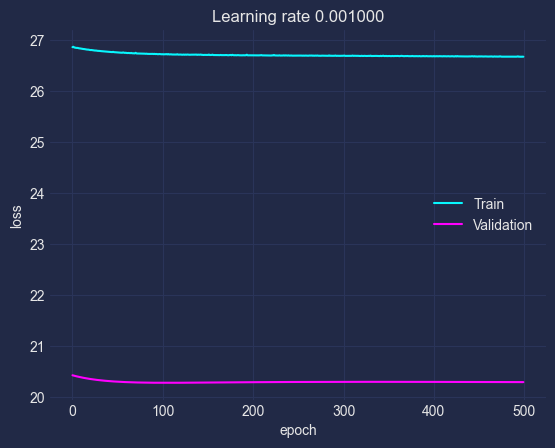

In [27]:
# エポック毎の訓練誤差と汎化誤差の近似値をプロット
plt.style.use("cyberpunk")
plt.plot(train_loss, label='Train')
plt.plot(val_loss, c='magenta', label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend()
plt.show()

### **4.　Neural Tangent Kernel**
線形回帰モデル向けの人工データを作り，人工データを最もよく説明する（＝訓練誤差の少ない）係数パラメータを求めよう

##### **問4：Neural Tangent Kernel**
観測データを生成する真のモデルが y = w0 + w1 * x + ε の場合，真のモデルから50個のサンプルを生成してください．<br>
また，作成した人工データをプロットしてください．ただし，係数パラメータ w0, w1 の値は自由に決めて良いとします．

##### **例4**

In [28]:
activations = {'relu': nn.ReLU,
               'tanh': nn.Tanh}

class zerooutput(nn.Module):
    """Zero the output of a model by subtracting out a copy of it."""
    def __init__(self, model):
        super().__init__()
        self.init_model = [copy.deepcopy(model).eval()]
        self.model = model

    def forward(self, X):
        return self.model(X) - self.init_model[0](X)

class scaling_factor(nn.Module):
    """Scale the output of the model by alpha."""
    def __init__(self, model, alpha):
        super().__init__()
        self.model = model
        self.alpha = alpha

    def forward(self, X):
        return self.alpha*self.model(X)

def simple_net(width,
               bias=True,
               alpha=1,
               zero_output=True,
               hidden_layers=1,
               act='relu',
               **kwargs):
    activation = activations[act]
    model = nn.Sequential(nn.Linear(1, width, bias=bias),
                          activation(),
                          *[layer 
                            for _ in range(hidden_layers-1)
                            for layer in [nn.Linear(width, width, bias=bias), activation()]],
                          nn.Linear(width, 1, bias=bias))
    if zero_output:
        model = zerooutput(model)
    model = scaling_factor(model, alpha)
    return model

Text(0, 0.5, '$f(x, w)$')

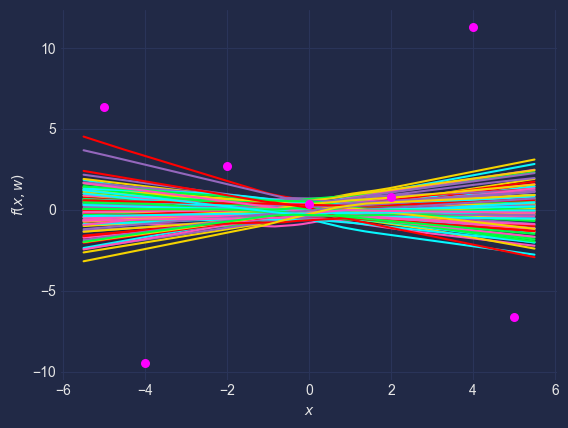

In [29]:
width = 10
model_samples = 100

# 人工データのサンプル数
num_samples = 100
X = torch.linspace(-5.5, 5.5, num_samples)
y = f(X)
X = X.unsqueeze(1).to(torch.float32)
y = y.unsqueeze(1).to(torch.float32)

Xin = torch.tensor([-5, -4, -2, 0, 2, 4, 5])
yin = f(Xin)
Xin = Xin.unsqueeze(1).to(torch.float32)
yin = yin.unsqueeze(1).to(torch.float32)

for i in range(model_samples):
    model = simple_net(width=width, bias=True, zero_output=False, alpha=1, hidden_layers=1)
    y_hat = model(X)
    plt.plot(X.detach(), y_hat.detach())
    
plt.scatter(Xin.detach(), yin.detach(), color='magenta', zorder=100, s=30)
plt.xlabel("$x$")
plt.ylabel("$f(x, w)$")

In [30]:
def compute_NTK(model, X):
    y_hat = model(X)
    param_vector = nn.utils.parameters_to_vector(model.parameters())
    p, = param_vector.shape                                      # パラメータ数
    n, outdim = y_hat.shape                                      # 入力の個数＝出力の個数
 
    features = torch.zeros(n, p, requires_grad=False)
    for i in range(n):                                           # 出力の個数だけloopを回す
        model.zero_grad()
        y_hat[i].backward(retain_graph=True)
        p_grad = torch.tensor([], requires_grad=False)
        for p in model.parameters():
            p_grad = torch.cat((p_grad, p.grad.reshape(-1)))     # パラメータ毎にヤコビアンの成分を計算
        features[i, :] = p_grad                                  # ある出力についてのヤコビアン

    K = features @ features.t()                                  # NTKを計算
    return features, K

def grad_descent(model, X, y,
                 iters=100,
                 lr=1e-3,
                 alpha=1,
                 eps=1e-10):
    optimizar = optim.SGD(model.parameters(), lr=lr)
    losses = []
    loss = 0
    for i in range(iters):
        y_hat = model(X)
        # 損失関数をスケーリングファクターαでリスケール
        normalized_loss = 1/(alpha**2) * nn.MSELoss()(y_hat, y)
        # リスケール前の損失関数を記録
        loss = normalized_loss.item()*(alpha**2)
        losses.append(loss)
        # 損失がeps以下になれば勾配更新を停止
        if loss < eps:
            return losses
        optimizar.zero_grad()
        normalized_loss.backward()
        optimizar.step()

    return losses

alpha		relative change in NTK norm
1.0000e-02	111.74455261230469
3.5938e-02	133.15478515625
1.2915e-01	137.21615600585938
4.6416e-01	1.5867811441421509
1.6681e+00	0.18911385536193848
5.9948e+00	0.01052169967442751
2.1544e+01	0.006319728679955006
7.7426e+01	0.002743139397352934
2.7826e+02	0.0004160365497227758
1.0000e+03	0.00010018357716035098



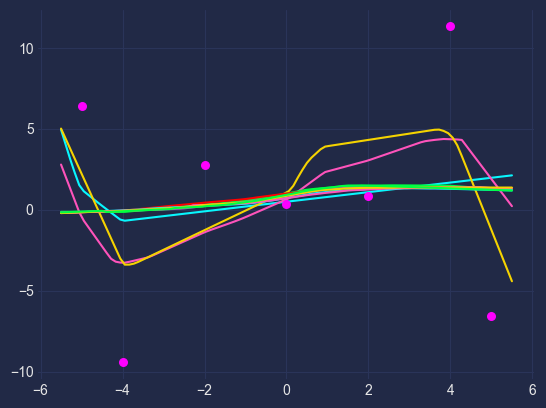

In [31]:
width = 10
model_samples = 5
alpha_powers = np.linspace(-2, 3, 10)
alphas = 10**alpha_powers

dels = []
out = ''
for alpha in list(alphas):
    del_dh = 0
    y_hat = torch.zeros([num_samples, 1], requires_grad=False, dtype=torch.float32)
    for i in range(model_samples):
        model = simple_net(width=width, bias=True, alpha=alpha, zero_output=True, hidden_layers=1)
        A0, K0 = compute_NTK(model, Xin)
        grad_descent(model, Xin, yin, alpha=alpha, iters=4000, lr=3e-4)
        A1, K1 = compute_NTK(model, Xin)
        y_hat += model(X)
        del_dh += torch.norm(K1-K0)/torch.norm(K0)
    y_hat = y_hat/model_samples
    plt.plot(X.detach(), y_hat.detach())
    dels.append(del_dh/model_samples)
    out += f'{alpha:.4e}\t{del_dh/model_samples}\n'

plt.scatter(Xin.detach(), yin.detach(), color='magenta', zorder=100, s=30)
print('alpha\t\trelative change in NTK norm')
print(out)

alpha		relative change in NTK norm
1.0000e-02	0.62105792760849
3.5938e-02	0.5819348096847534
1.2915e-01	0.30609413981437683
4.6416e-01	0.07682384550571442
1.6681e+00	0.10822810977697372
5.9948e+00	0.11825196444988251
2.1544e+01	0.08134353905916214
7.7426e+01	0.11207008361816406
2.7826e+02	0.094968780875206
1.0000e+03	0.09704644232988358



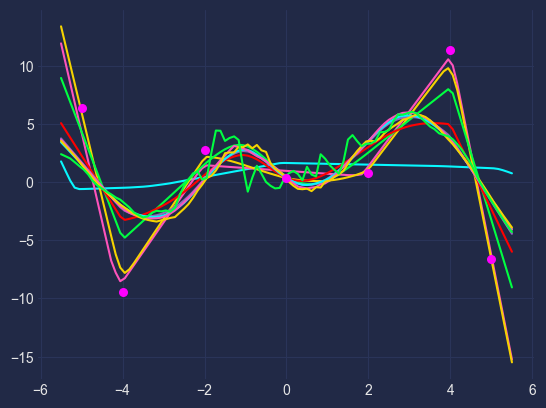

In [32]:
width = 3 * 10**3
model_samples = 5
alpha_powers = np.linspace(-2, 3, 10)
alphas = 10**alpha_powers

dels = []
out = ''
for alpha in list(alphas):
    del_dh = 0
    y_hat = torch.zeros([num_samples, 1], requires_grad=False, dtype=torch.float32)
    for i in range(model_samples):
        model = simple_net(width=width, bias=True, alpha=alpha, zero_output=True, hidden_layers=1)
        A0, K0 = compute_NTK(model, Xin)
        grad_descent(model, Xin, yin, alpha=alpha, iters=4000, lr=3e-4)
        A1, K1 = compute_NTK(model, Xin)
        y_hat += model(X)
        del_dh += torch.norm(K1-K0)/torch.norm(K0)
    y_hat = y_hat/model_samples
    plt.plot(X.detach(), y_hat.detach())
    dels.append(del_dh/model_samples)
    out += f'{alpha:.4e}\t{del_dh/model_samples}\n'

plt.scatter(Xin.detach(), yin.detach(), color='magenta', zorder=100, s=30)
print('alpha\t\trelative change in NTK norm')
print(out)

### **5.　ニューラルネットを使った分類器**
線形回帰モデル向けの人工データを作り，人工データを最もよく説明する（＝訓練誤差の少ない）係数パラメータを求めよう

##### **問5：ニューラルネットを使った分類器**
観測データを生成する真のモデルが y = w0 + w1 * x + ε の場合，真のモデルから50個のサンプルを生成してください．<br>
また，作成した人工データをプロットしてください．ただし，係数パラメータ w0, w1 の値は自由に決めて良いとします．

##### **例5**

In [33]:
from sklearn.datasets import make_circles

# サンプル数を1000に設定
num_samples = 1000

# Create circles
X, y = make_circles(num_samples, 
                    noise=0.03, 
                    random_state=42)

circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})

# y=0がいくつあるのか，y=1がいくつあるのか確認
#circles.label.value_counts()

circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


Text(0, 0.5, '$X2$')

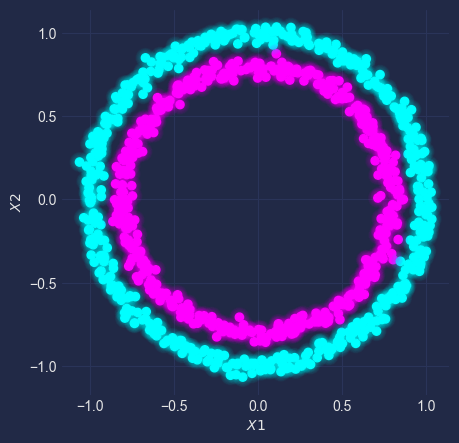

In [34]:
plt.style.use("cyberpunk")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X[:, 0], X[:, 1], c=y)
mplcyberpunk.make_scatter_glow()
ax.set_xlabel('$X1$')
ax.set_ylabel('$X2$')

In [35]:
def plot_decision_boundary(model, X, y):
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                       np.linspace(y_min, y_max, 1000))
  
  x_in = np.c_[xx.ravel(), yy.ravel()]
  x_in = torch.tensor(x_in).to(torch.float32)
    
  # Make predictions using the trained model
  y_hat= model(x_in)
  y_hat = torch.round(torch.max(y_hat, axis=1)[0]).reshape(xx.shape)
    
  # Plot decision boundary
  plt.style.use("cyberpunk")
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.pcolormesh(xx, yy, y_hat.detach().numpy(), alpha=0.7)
  ax.scatter(X[:, 0], X[:, 1], c=y, s=40)
  mplcyberpunk.make_scatter_glow()
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())

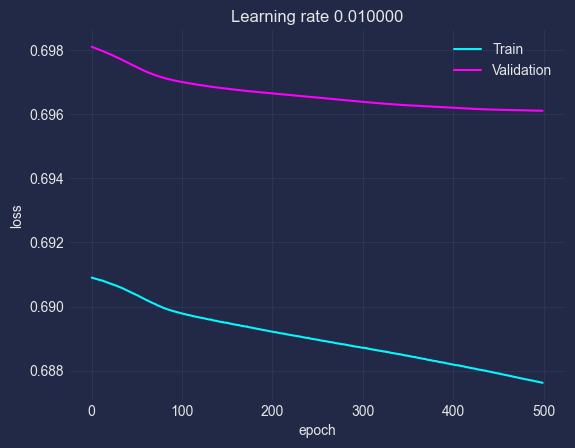

In [36]:
# 中間層の幅
width = 10
# エポック数
epochs = 500
# 学習率
learning_rate = 1/100
# バッチサイズ
train_batch_size = int(0.8 * num_samples/2)
# バッチサイズ
val_batch_size = int(0.2 * num_samples/2)

    
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.classifier = nn.Sequential(nn.Linear(2, width),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(width, width),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(width, 1),
                                       nn.Sigmoid())
    def forward(self, X):
        y_hat = self.classifier(X)
        return y_hat

model1 = NeuralNetwork()

criterion = nn.BCELoss()
optimizer = optim.SGD(model1.parameters(), lr=learning_rate)

X = torch.tensor(X).to(torch.float32)
y = torch.tensor(y).to(torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train_loader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=train_batch_size,
                          pin_memory=True, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=val_batch_size,
                        pin_memory=True, shuffle=True)

train_loss = []
val_loss = []
for epoch in np.arange(epochs):
    # エポック毎にモデルの訓練と評価を繰り返す
    # モデルの訓練
    model1.train()
    temp_train_loss = []
    for X_train, y_train in train_loader:             # データローダーから訓練データ（バッチ）を抽出
        optimizer.zero_grad()                         # 勾配情報を初期化
        y_hat = model1(X_train).squeeze(1)            # 出力の予測値を生成
        loss = criterion(input=y_hat, target=y_train) # 損失関数に出力の予測値と正解の出力を代入し訓練誤差を計算
        loss.backward()                               # パラメータ毎に訓練誤差の勾配を計算
        optimizer.step()                              # 勾配降下法によるパラメータ更新
        temp_train_loss.append(loss.detach())
    train_loss.append(np.average(temp_train_loss))    # 訓練誤差をリストに保存
    # モデルの評価
    model1.eval()
    temp_val_loss = []
    for X_val, y_val in val_loader:
        y_hat = model1(X_val).squeeze(1)              # データローダーからテストデータ（バッチ）を抽出
        loss = criterion(input=y_hat, target=y_val)   # 損失関数に出力の予測値と正解の出力を代入して汎化誤差の近似値を計算
        temp_val_loss.append(loss.detach())
    val_loss.append(np.average(temp_val_loss))        # 汎化誤差の近似値をリストに保存
    
plt.style.use("cyberpunk")
plt.plot(train_loss, label='Train')
plt.plot(val_loss, c='magenta', label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend()
plt.show()

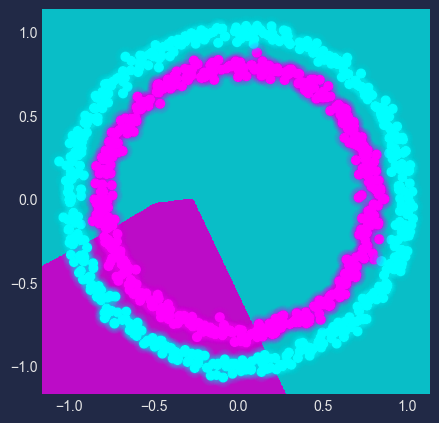

In [37]:
plot_decision_boundary(model1, X, y)

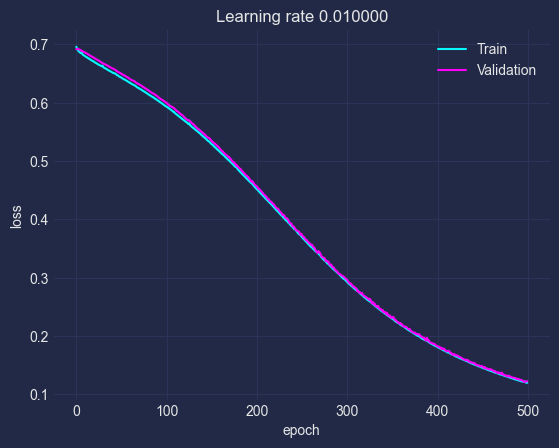

In [38]:
# 中間層の幅
width = 3 * 10**3
# エポック数
epochs = 500
# 学習率
learning_rate = 1/100
# バッチサイズ
train_batch_size = int(0.8 * num_samples/2)
# バッチサイズ
val_batch_size = int(0.2 * num_samples/2)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.classifier = nn.Sequential(nn.Linear(2, width),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(width, width),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(width, 1),
                                       nn.Sigmoid())
    def forward(self, X):
        y_hat = self.classifier(X)
        return y_hat

model2 = NeuralNetwork()

criterion = nn.BCELoss()
optimizer = optim.SGD(model2.parameters(), lr=learning_rate)

X = torch.tensor(X).to(torch.float32)
y = torch.tensor(y).to(torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train_loader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=train_batch_size,
                          pin_memory=True, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=val_batch_size,
                        pin_memory=True, shuffle=True)

train_loss = []
val_loss = []
for epoch in np.arange(epochs):
    # エポック毎にモデルの訓練と評価を繰り返す
    # モデルの訓練
    model2.train()
    temp_train_loss = []
    for X_train, y_train in train_loader:             # データローダーから訓練データ（バッチ）を抽出
        optimizer.zero_grad()                         # 勾配情報を初期化
        y_hat = model2(X_train).squeeze(1)            # 出力の予測値を生成
        loss = criterion(input=y_hat, target=y_train) # 損失関数に出力の予測値と正解の出力を代入し訓練誤差を計算
        loss.backward()                               # パラメータ毎に訓練誤差の勾配を計算
        optimizer.step()                              # 勾配降下法によるパラメータ更新
        temp_train_loss.append(loss.detach())
    train_loss.append(np.average(temp_train_loss))    # 訓練誤差をリストに保存
    # モデルの評価
    model2.eval()
    temp_val_loss = []
    for X_val, y_val in val_loader:
        y_hat = model2(X_val).squeeze(1)              # データローダーからテストデータ（バッチ）を抽出
        loss = criterion(input=y_hat, target=y_val)   # 損失関数に出力の予測値と正解の出力を代入して汎化誤差の近似値を計算
        temp_val_loss.append(loss.detach())
    val_loss.append(np.average(temp_val_loss))        # 汎化誤差の近似値をリストに保存
    
plt.style.use("cyberpunk")
plt.plot(train_loss, label='Train')
plt.plot(val_loss, c='magenta', label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend()
plt.show()

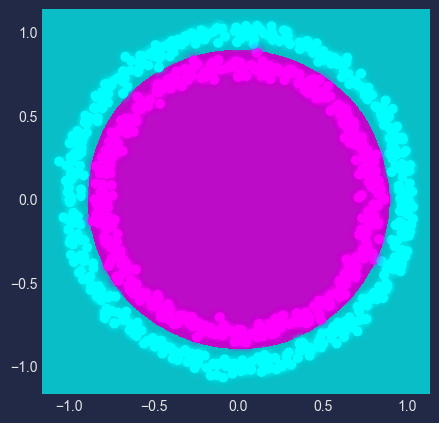

In [39]:
plot_decision_boundary(model2, X, y)

In [40]:
%load_ext watermark
%watermark --iversions

numpy          : 1.22.4
loss_landscapes: 3.0.6
mplcyberpunk   : 0.6.0
torch          : 1.13.0
matplotlib     : 3.6.0
pandas         : 1.5.0

